In [ ]:
# !pip uninstall tensorflow tensorflow-tensorboard tensorflow-estimator
!pip install gdown
!pip install tensorflow-gpu

In [119]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [120]:
df = pd.read_csv(
  "/home/jovyan/work/training_data/sw_training_data.csv", 
  parse_dates=['read_date'], 
  index_col="read_date"
)

In [121]:
df = df.drop(['bl_meter1','bl_meter2','bl_meter3','bl_ahd3','mean_temp3','bl_meter4','bl_ahd4','mean_temp4','sl_meter','rf_meter'
             ],axis=1)

In [122]:
df.shape

(5316, 6)

In [123]:
df.head()

,sl_read1,bl_ahd1,mean_temp1,bl_ahd2,mean_temp2,rf_read1
read_date,,,,,,
2005-12-02,0.295,253.271,19.800,251.641,21.400,19.8
2005-12-03,0.303,253.277,19.825,251.644,21.350,21.4
2005-12-04,0.307,253.278,19.800,251.639,21.375,0.0
2005-12-05,0.303,253.275,19.824,251.636,21.375,0.0
2005-12-06,0.304,253.273,19.801,251.638,21.400,0.0


In [124]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

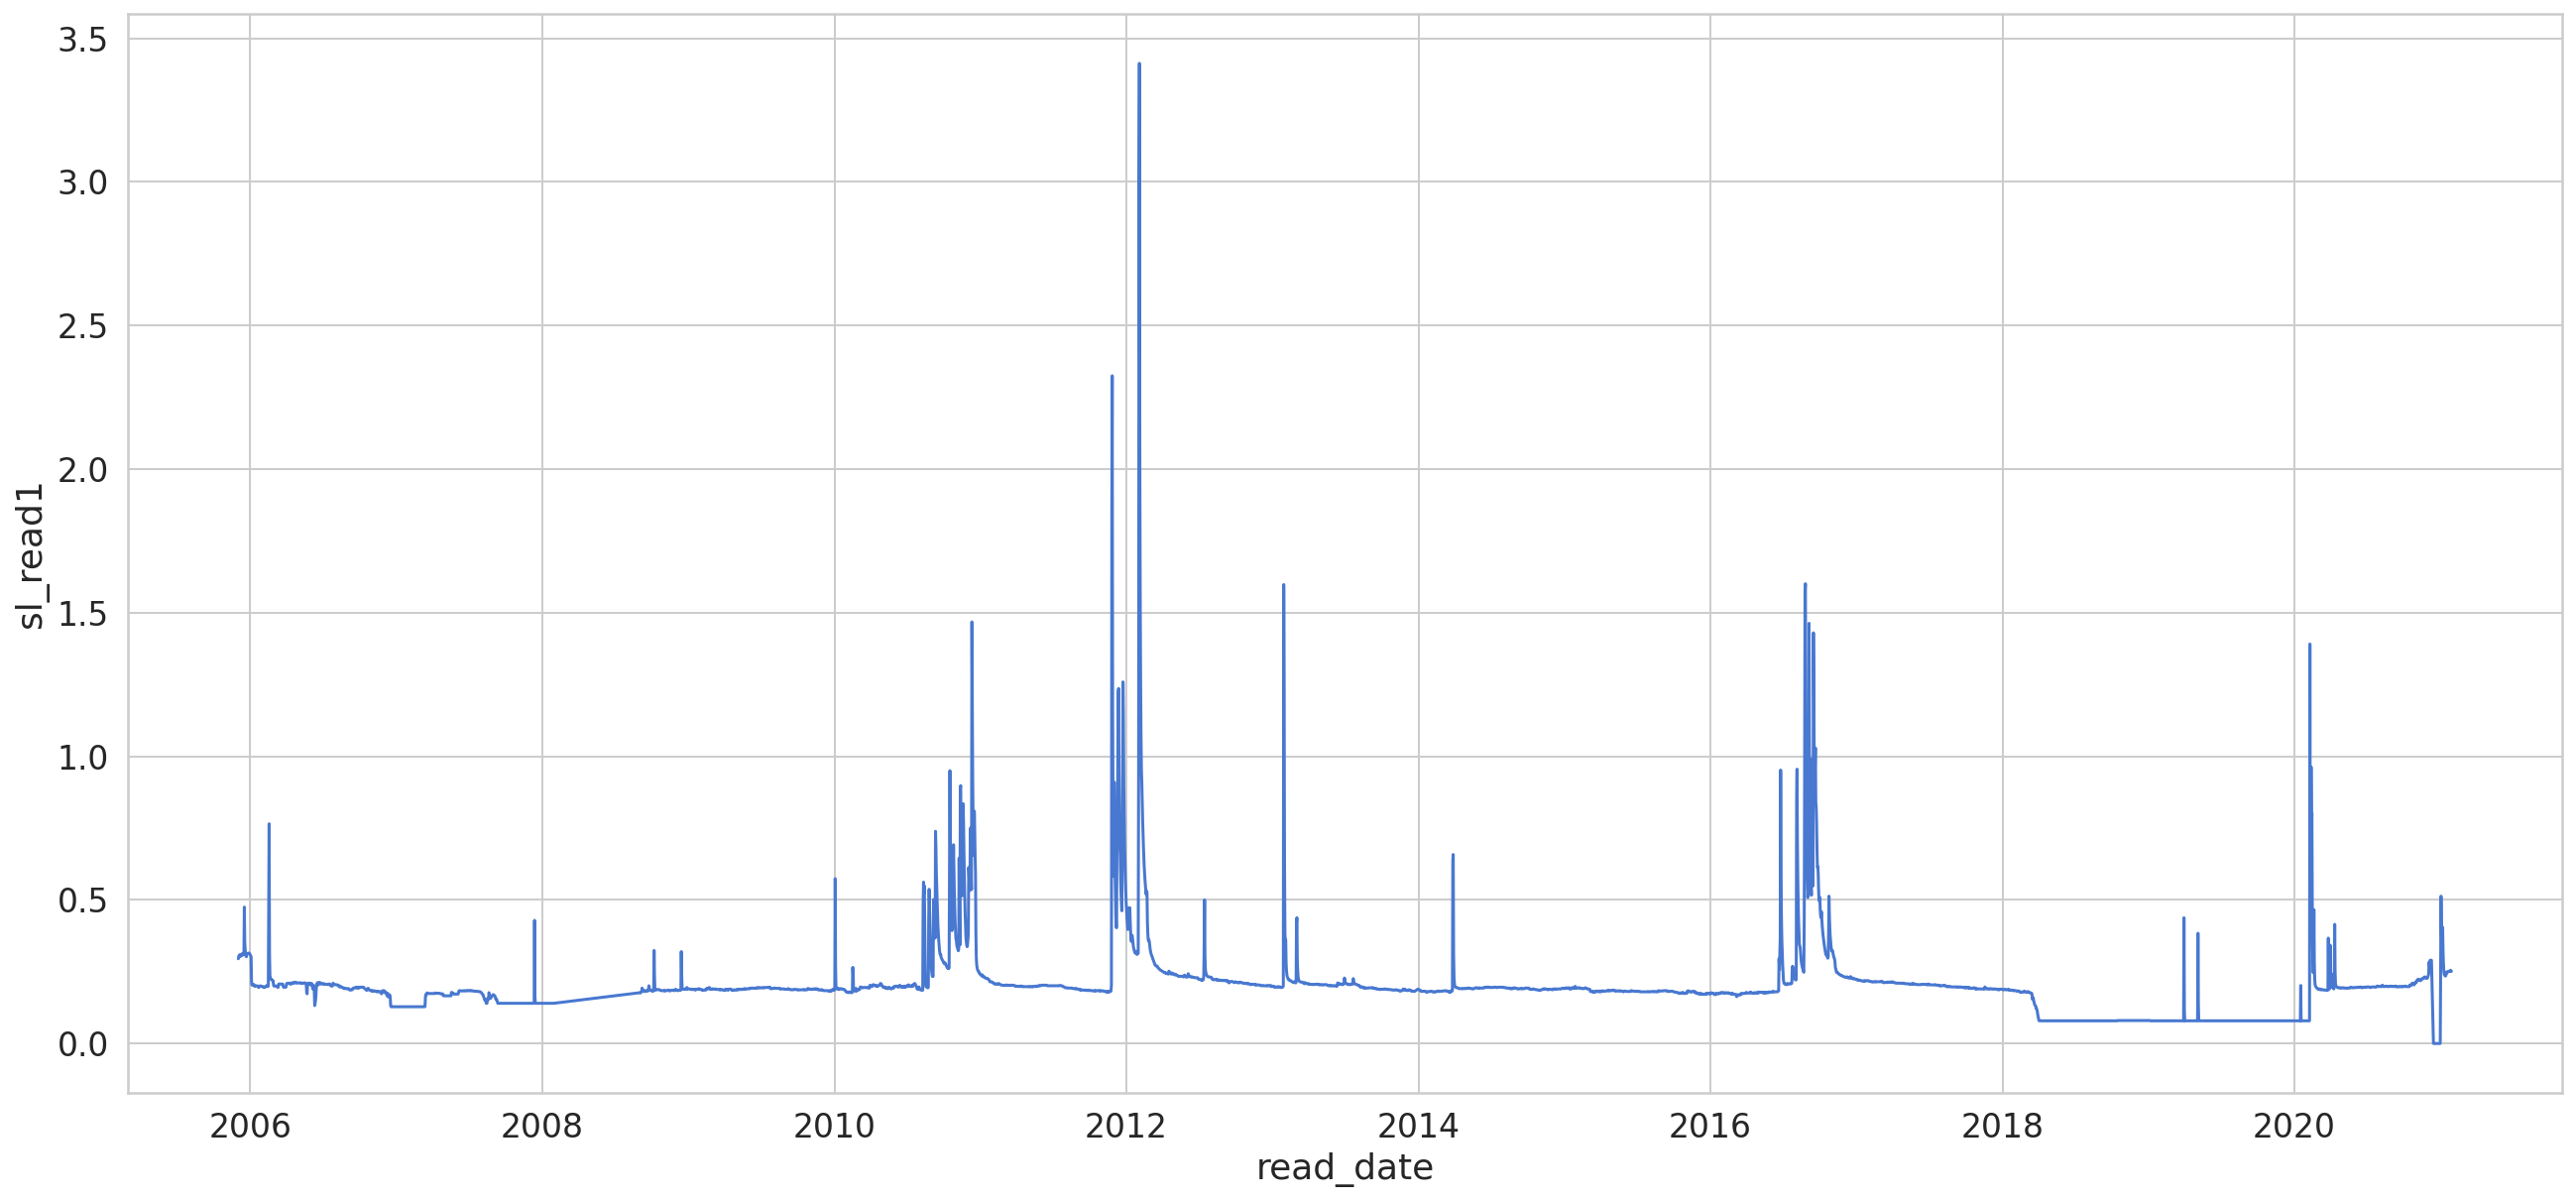

In [125]:
sns.lineplot(x=df.index, y="sl_read1", data=df);

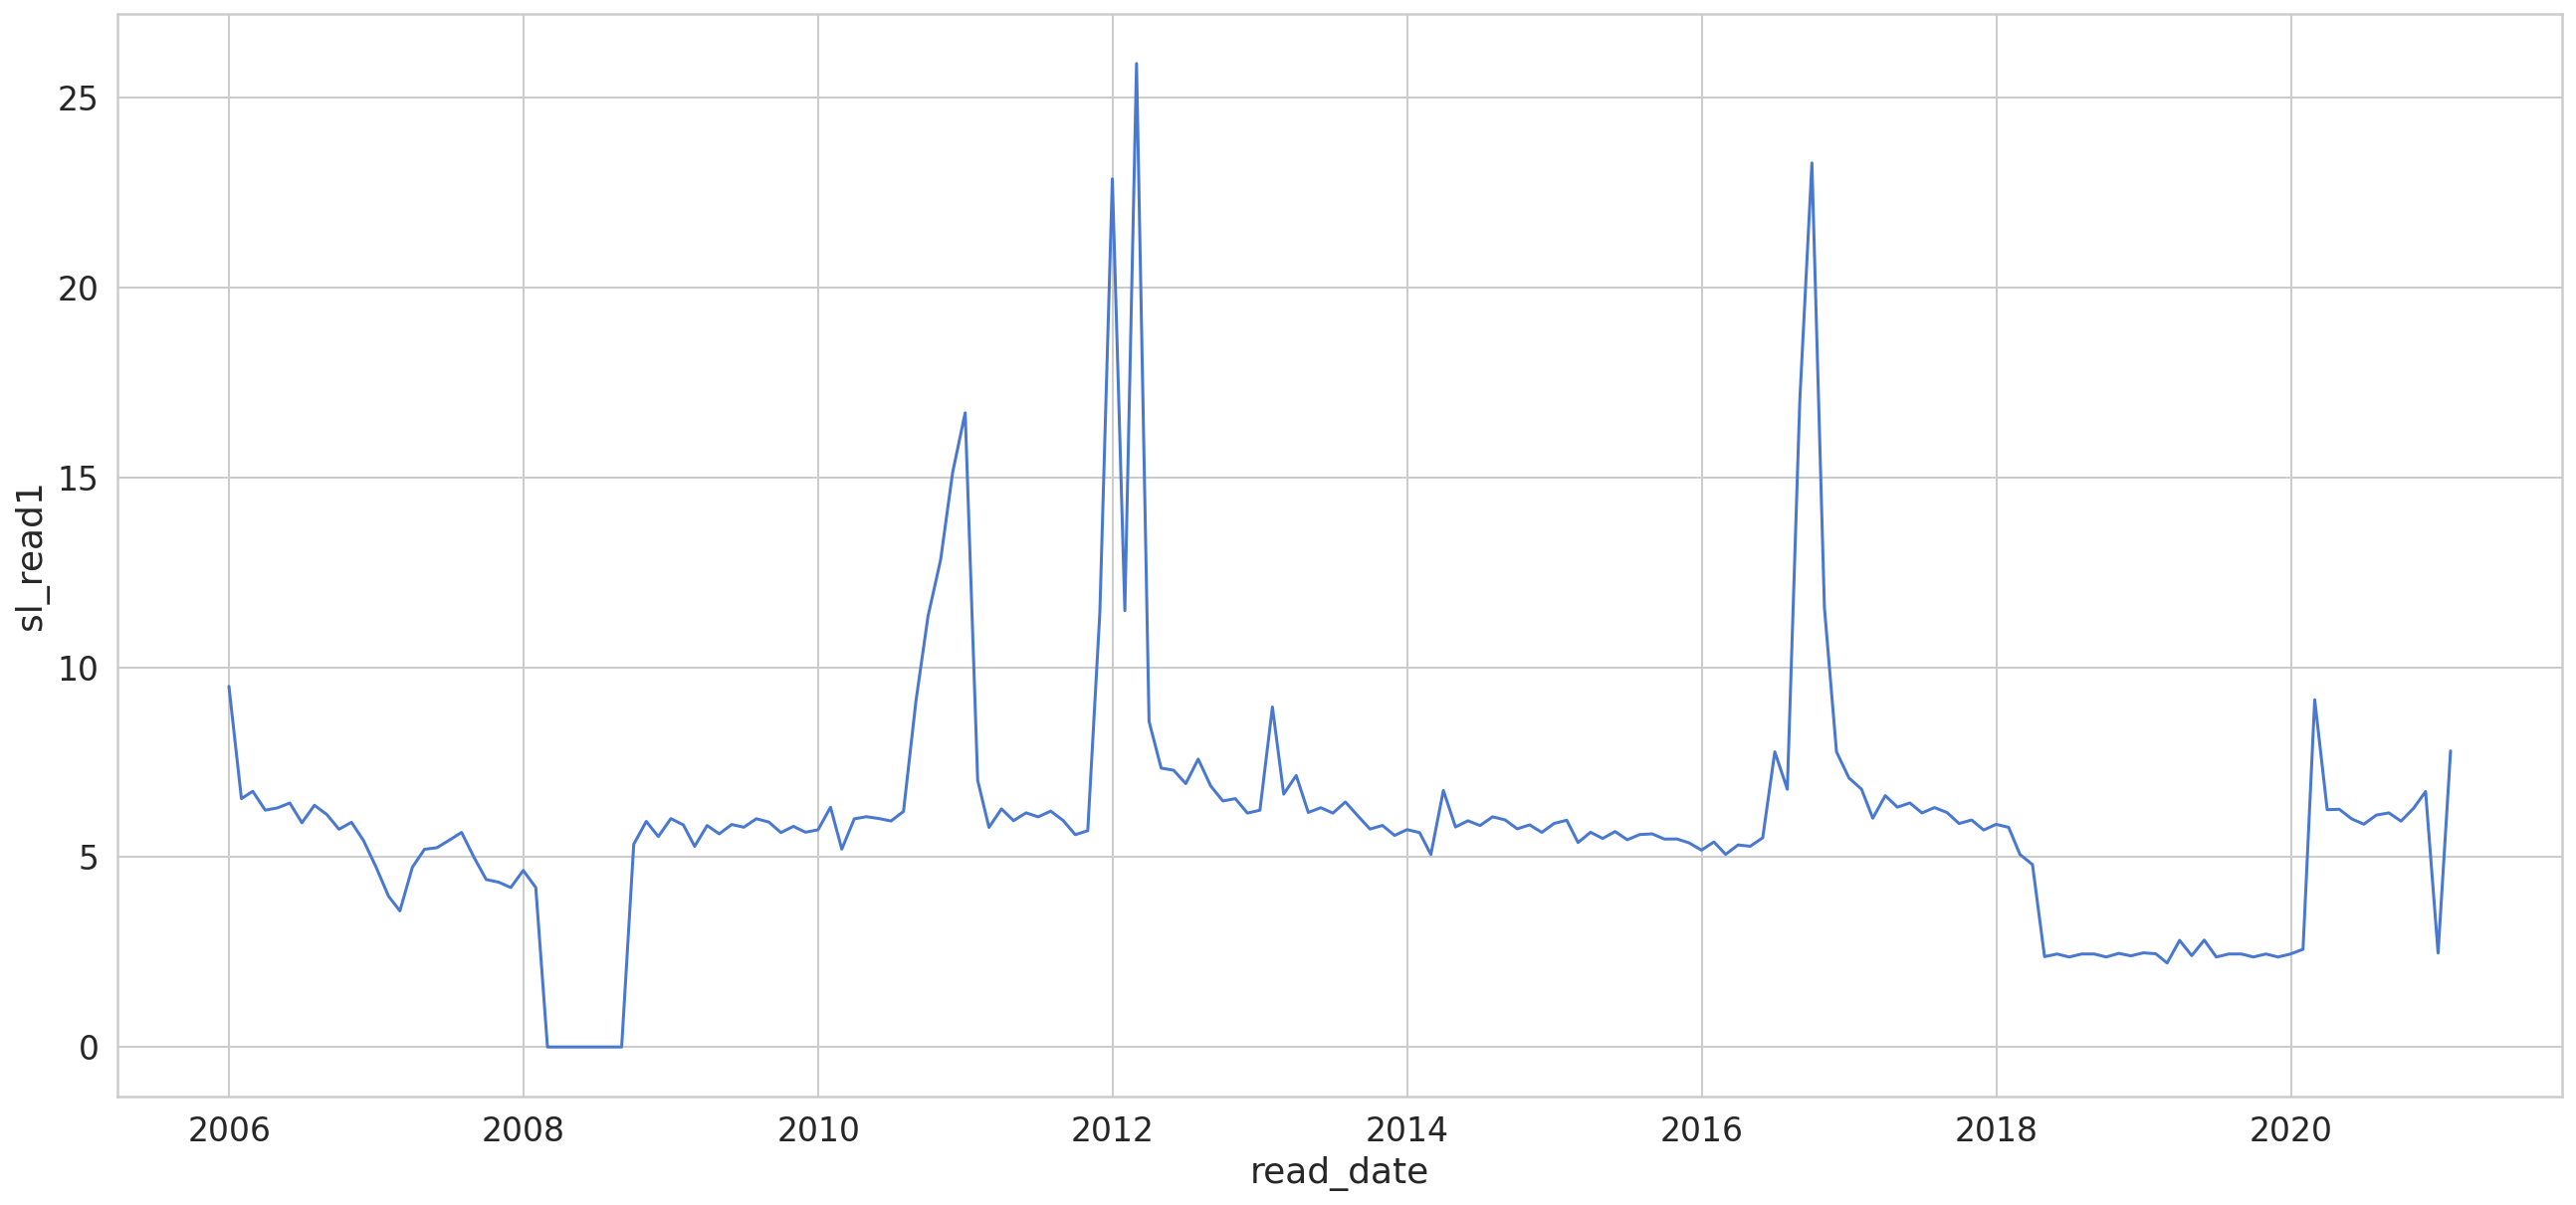

In [126]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="sl_read1", data=df_by_month);

In [127]:
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

4252 1064


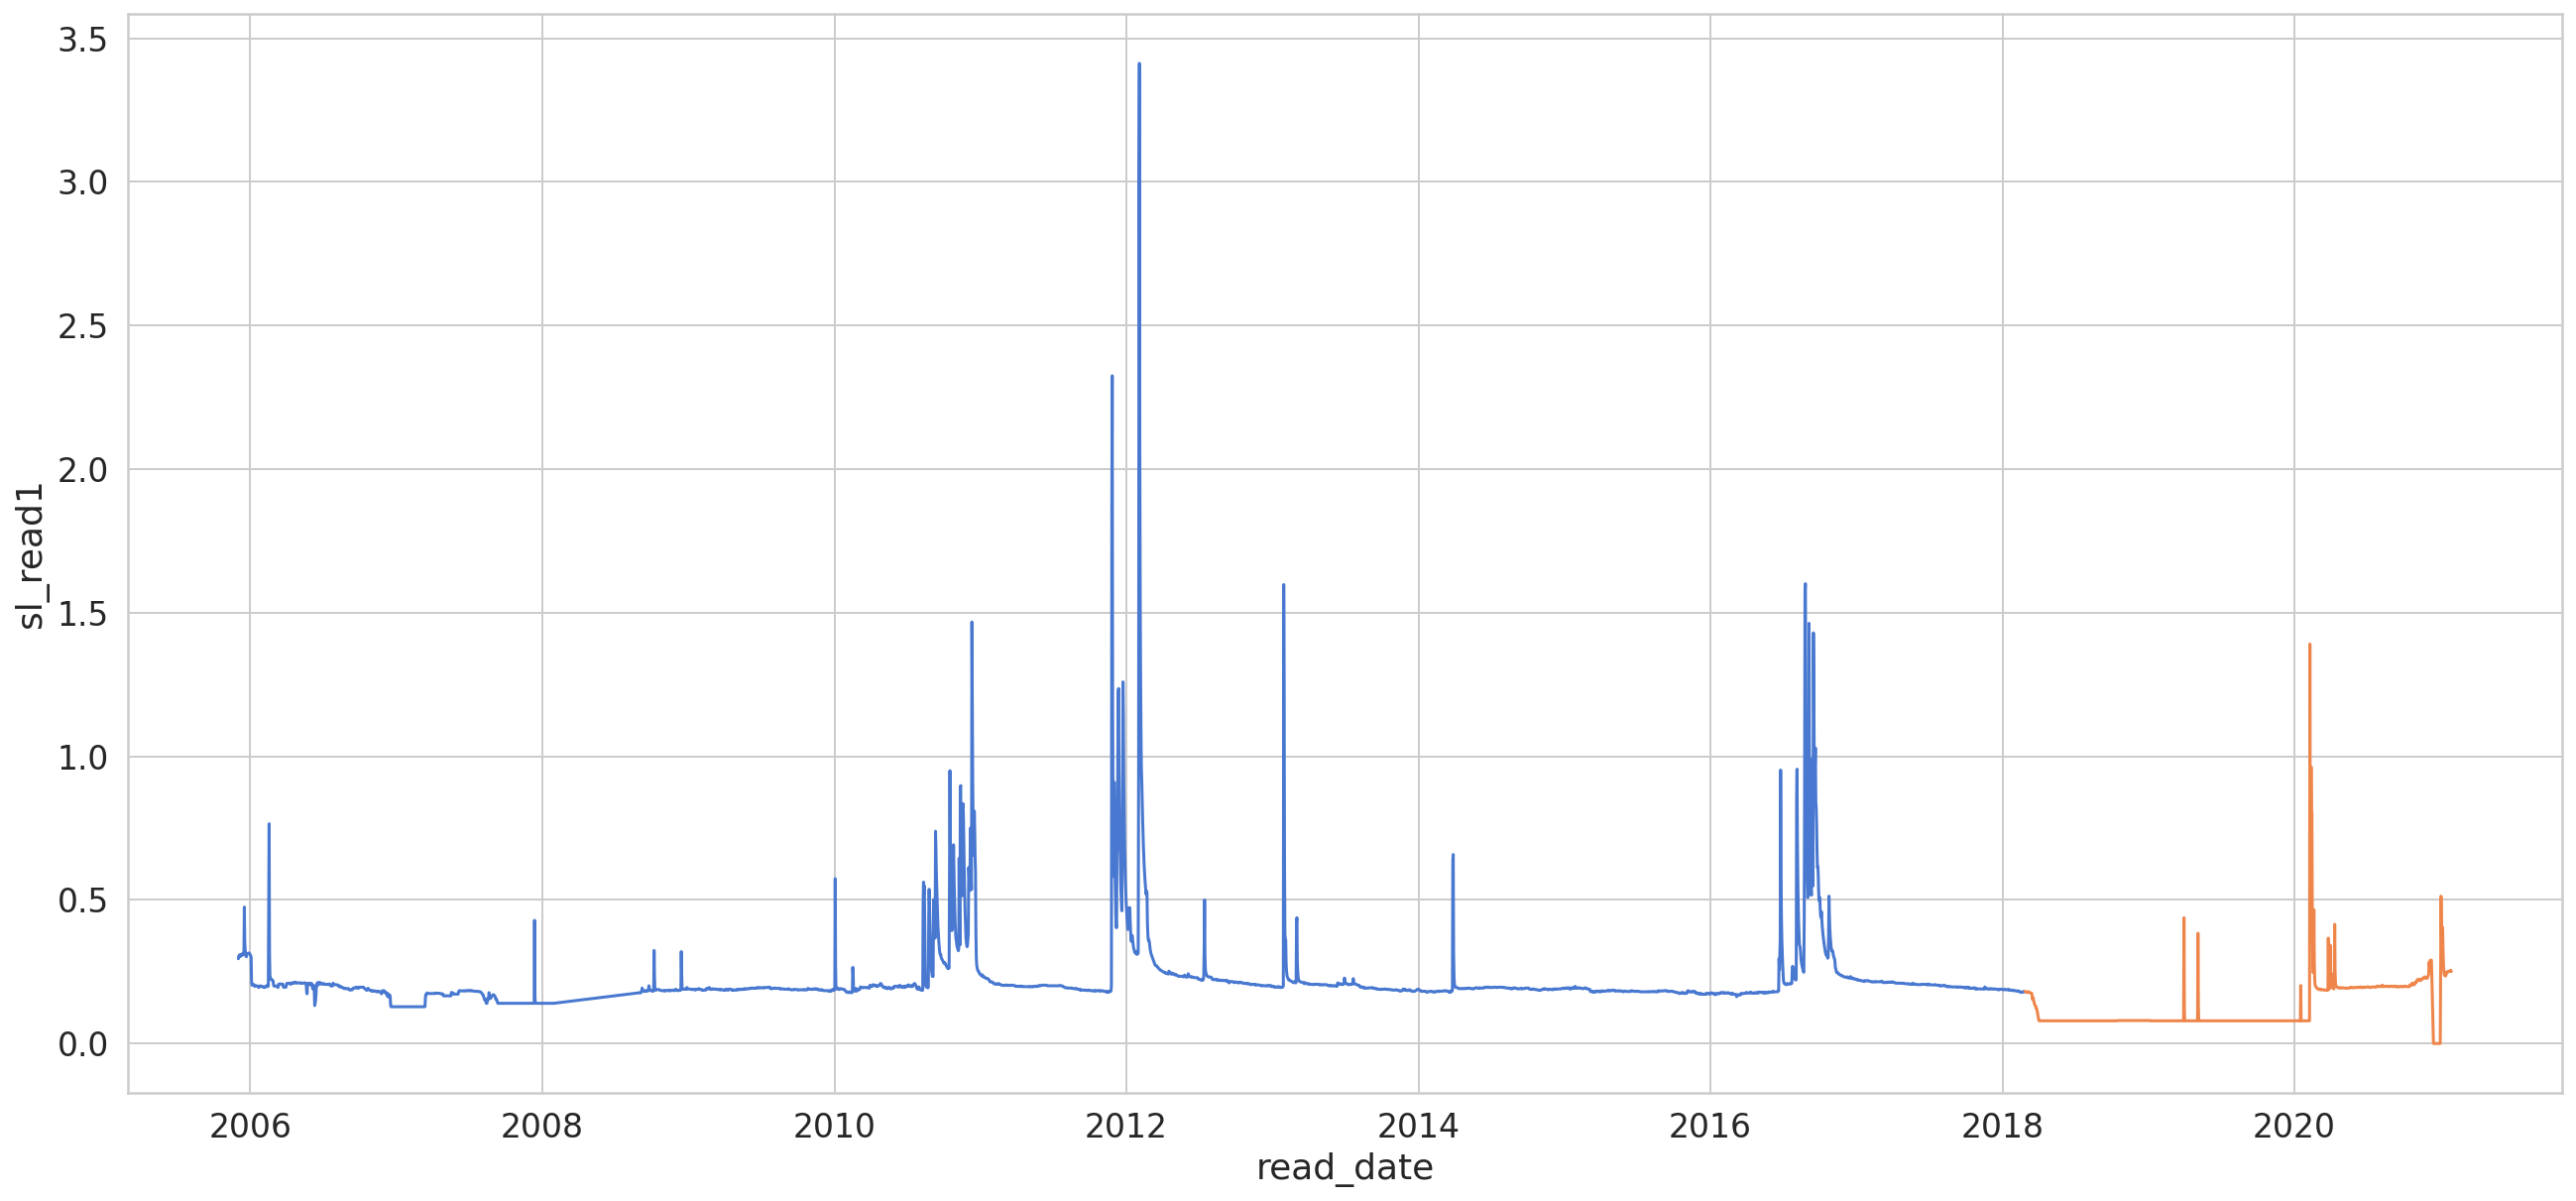

In [128]:
sns.lineplot(x=train.index, y="sl_read1", data=train);
sns.lineplot(x=test.index, y="sl_read1", data=test);

In [129]:
from sklearn.preprocessing import RobustScaler

#f_columns = ['t1', 't2', 'hum', 'wind_speed']
f_columns = ['bl_ahd1', 'mean_temp1', 'bl_ahd2', 'mean_temp2','rf_read1'] 

f_transformer = RobustScaler()
sl_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
sl_transformer = sl_transformer.fit(train[['sl_read1']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['sl_read1'] = sl_transformer.transform(train[['sl_read1']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['sl_read1'] = sl_transformer.transform(test[['sl_read1']])


#from sklearn.preprocessing import RobustScaler
#
#f_columns = ['t1', 't2', 'hum', 'wind_speed']
#
#f_transformer = RobustScaler()
#cnt_transformer = RobustScaler()
#
#f_transformer = f_transformer.fit(train[f_columns].to_numpy())
#cnt_transformer = cnt_transformer.fit(train[['cnt']])
#
#train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
#train['cnt'] = cnt_transformer.transform(train[['cnt']])
#
#test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
#test['cnt'] = cnt_transformer.transform(test[['cnt']])


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-129-d395f02981c5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['sl_read1'] = sl_transformer.transform(train[['sl_read1']])
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [130]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [131]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.sl_read1, time_steps)
X_test, y_test = create_dataset(test, test.sl_read1, time_steps)

print(X_train.shape, y_train.shape)

(4242, 10, 10) (4242,)


In [132]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [133]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
120/120 [==============================] - 5s 20ms/step - loss: 21.4664 - val_loss: 0.5235
Epoch 2/30
120/120 [==============================] - 1s 12ms/step - loss: 15.1649 - val_loss: 0.5375
Epoch 3/30
120/120 [==============================] - 1s 12ms/step - loss: 13.0697 - val_loss: 0.3636
Epoch 4/30
120/120 [==============================] - 2s 13ms/step - loss: 11.1105 - val_loss: 0.4341
Epoch 5/30
120/120 [==============================] - 2s 12ms/step - loss: 11.0470 - val_loss: 0.2333
Epoch 6/30
120/120 [==============================] - 1s 12ms/step - loss: 9.9094 - val_loss: 0.5425
Epoch 7/30
120/120 [==============================] - 1s 12ms/step - loss: 9.3389 - val_loss: 0.2951
Epoch 8/30
120/120 [==============================] - 1s 12ms/step - loss: 9.0506 - val_loss: 0.8880
Epoch 9/30
120/120 [==============================] - 2s 13ms/step - loss: 8.6477 - val_loss: 0.3313
Epoch 10/30
120/120 [==============================] - 1s 12ms/step - loss: 7.6935 - v

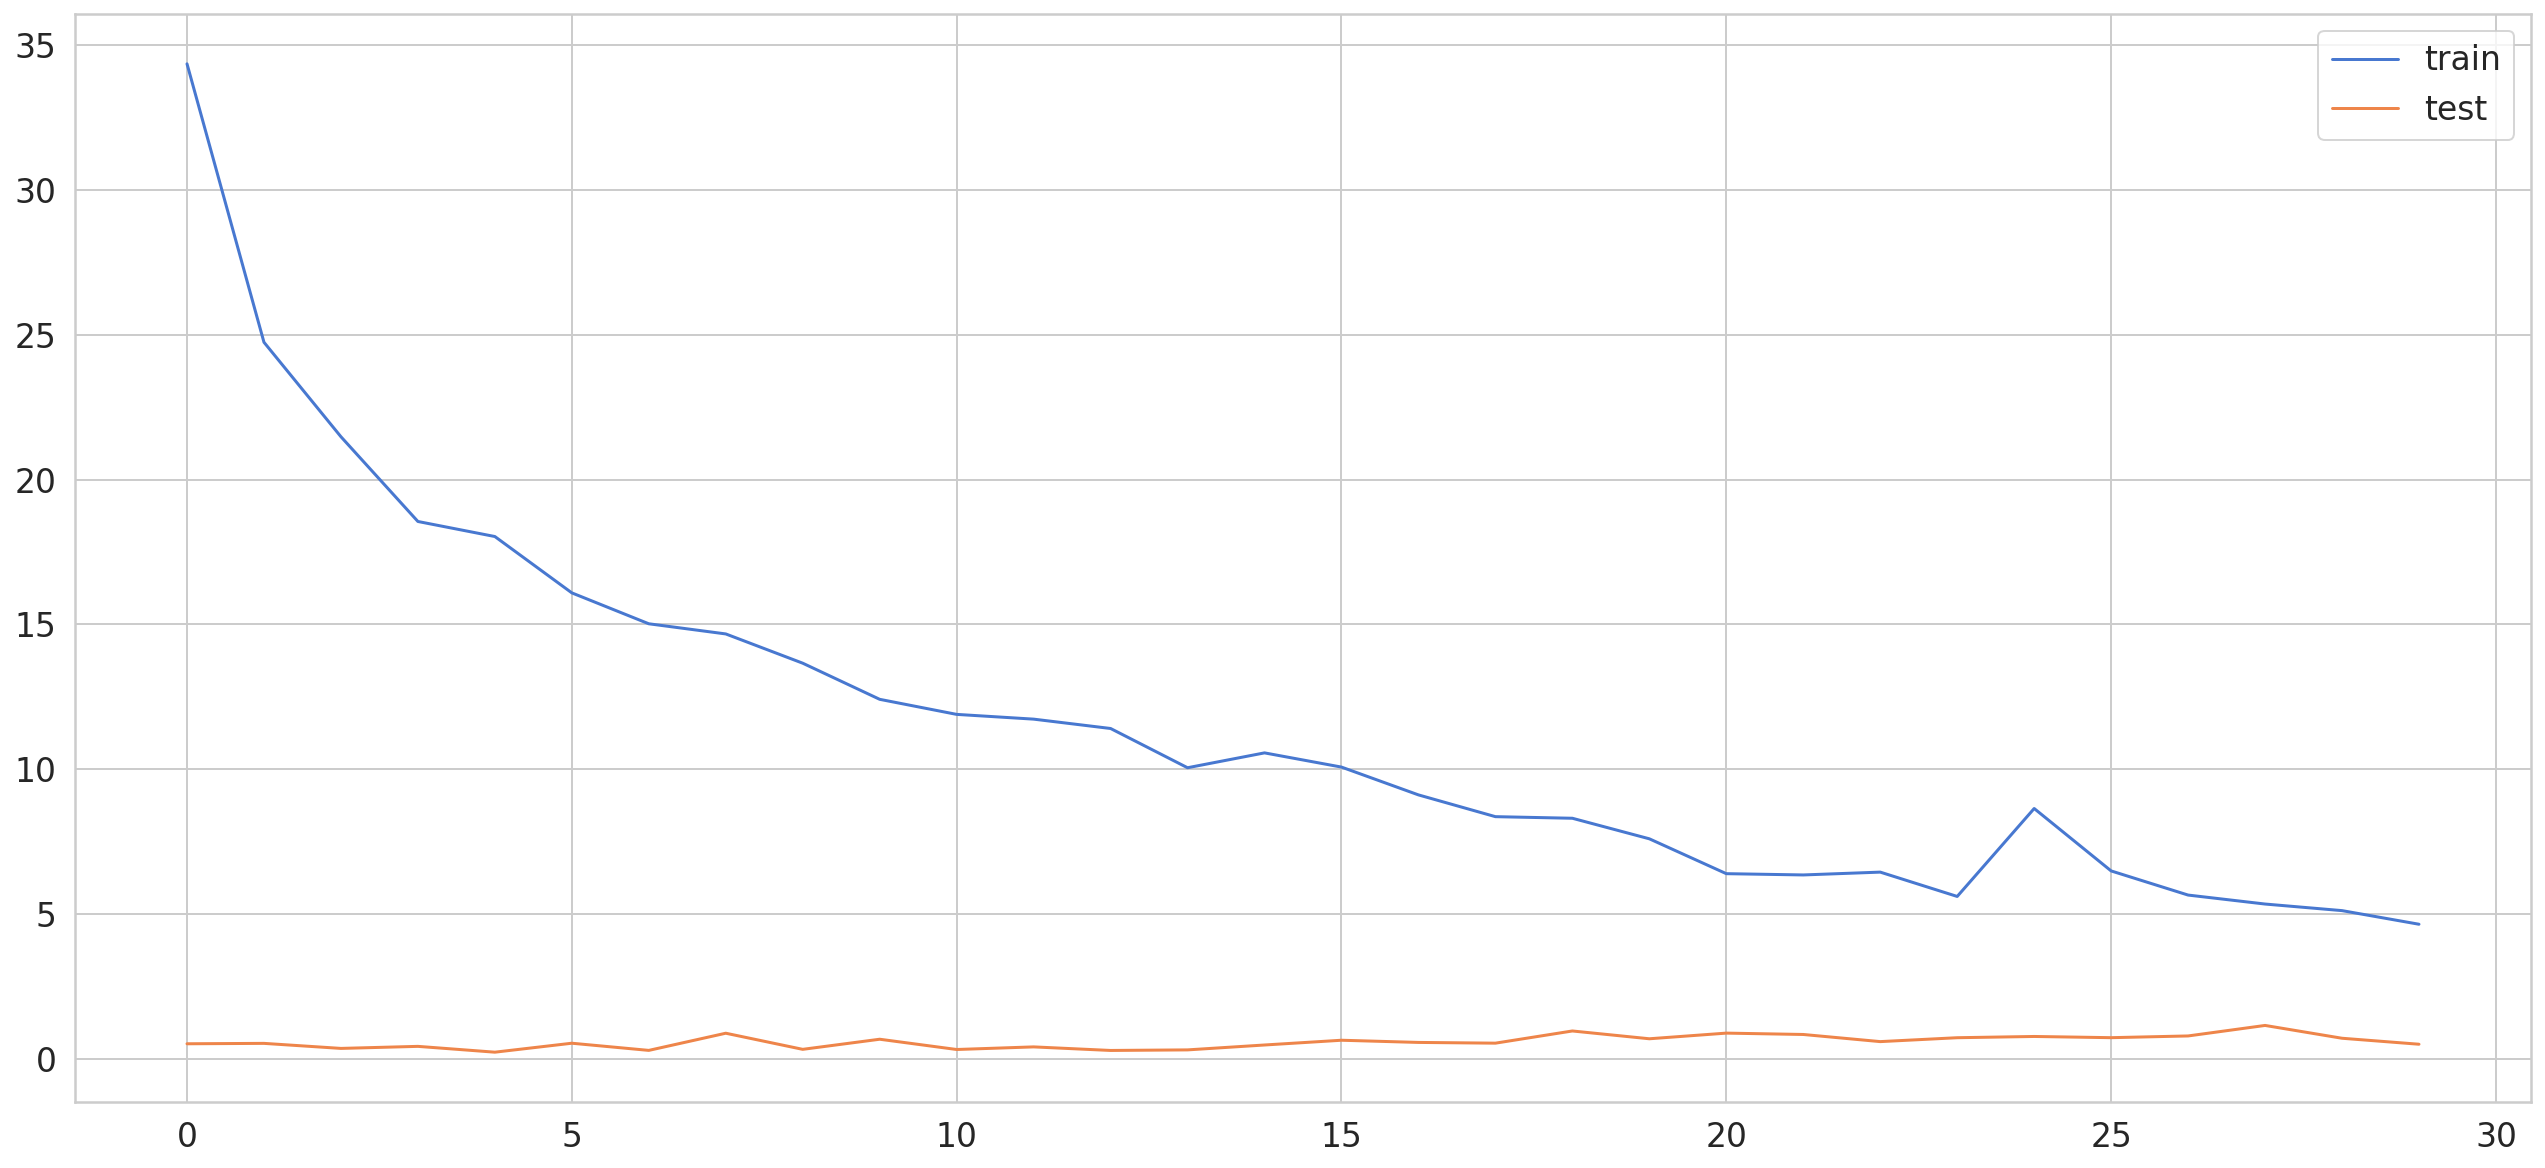

In [134]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [135]:
y_pred = model.predict(X_test)

In [136]:
y_train_inv = sl_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = sl_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = sl_transformer.inverse_transform(y_pred)

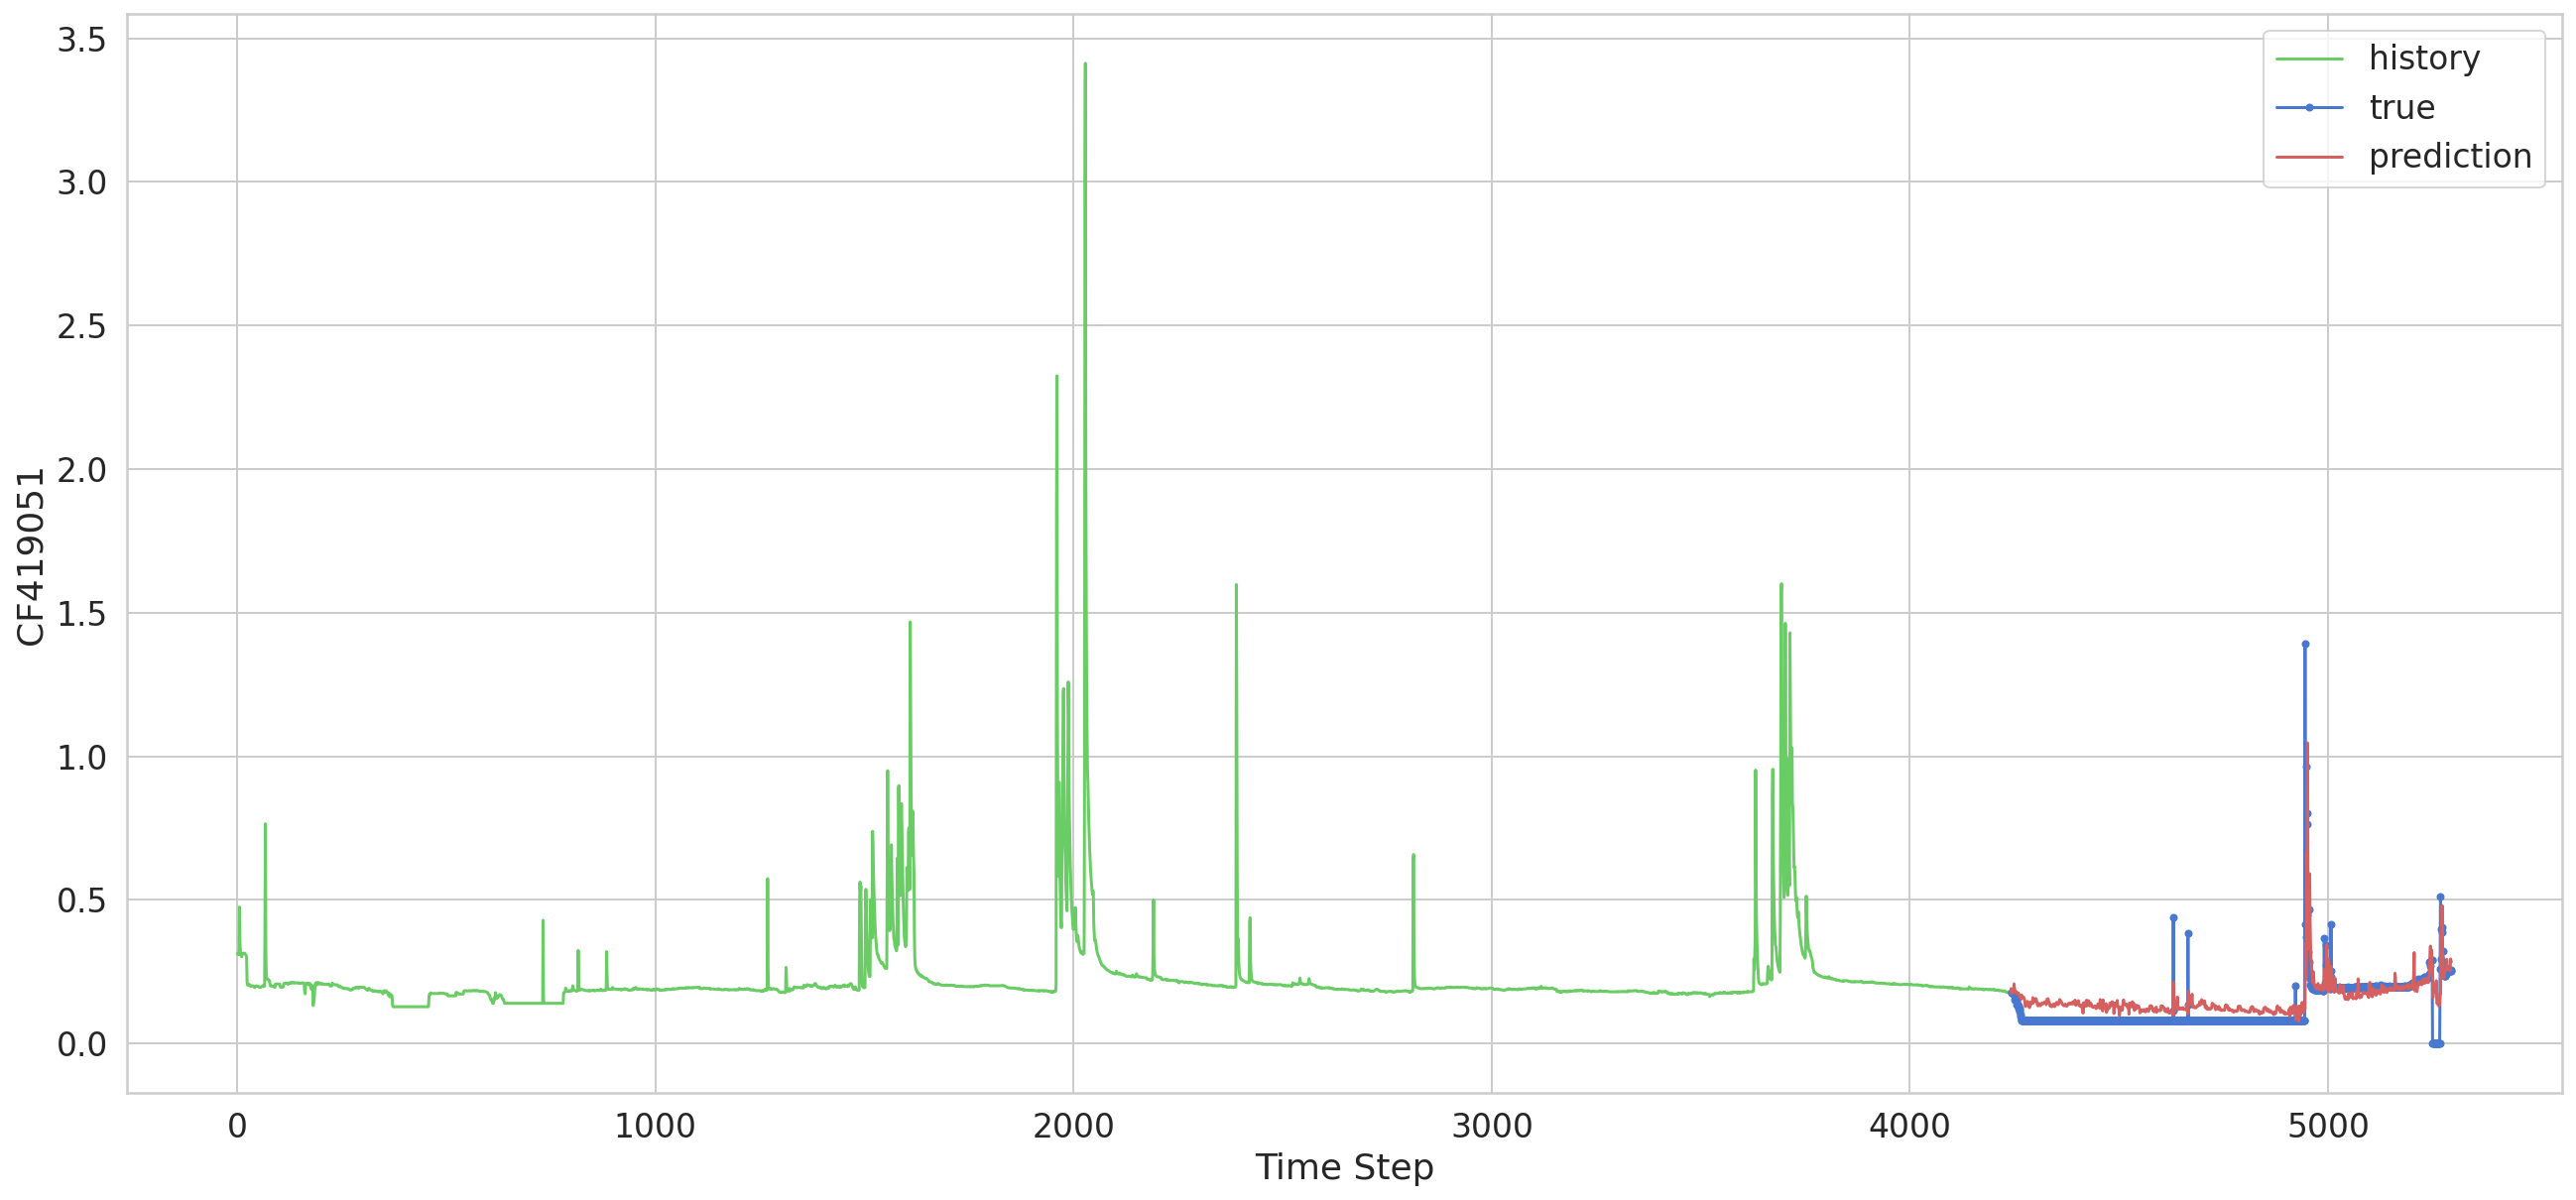

In [137]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('CF419051')
plt.xlabel('Time Step')
plt.legend()
plt.show();

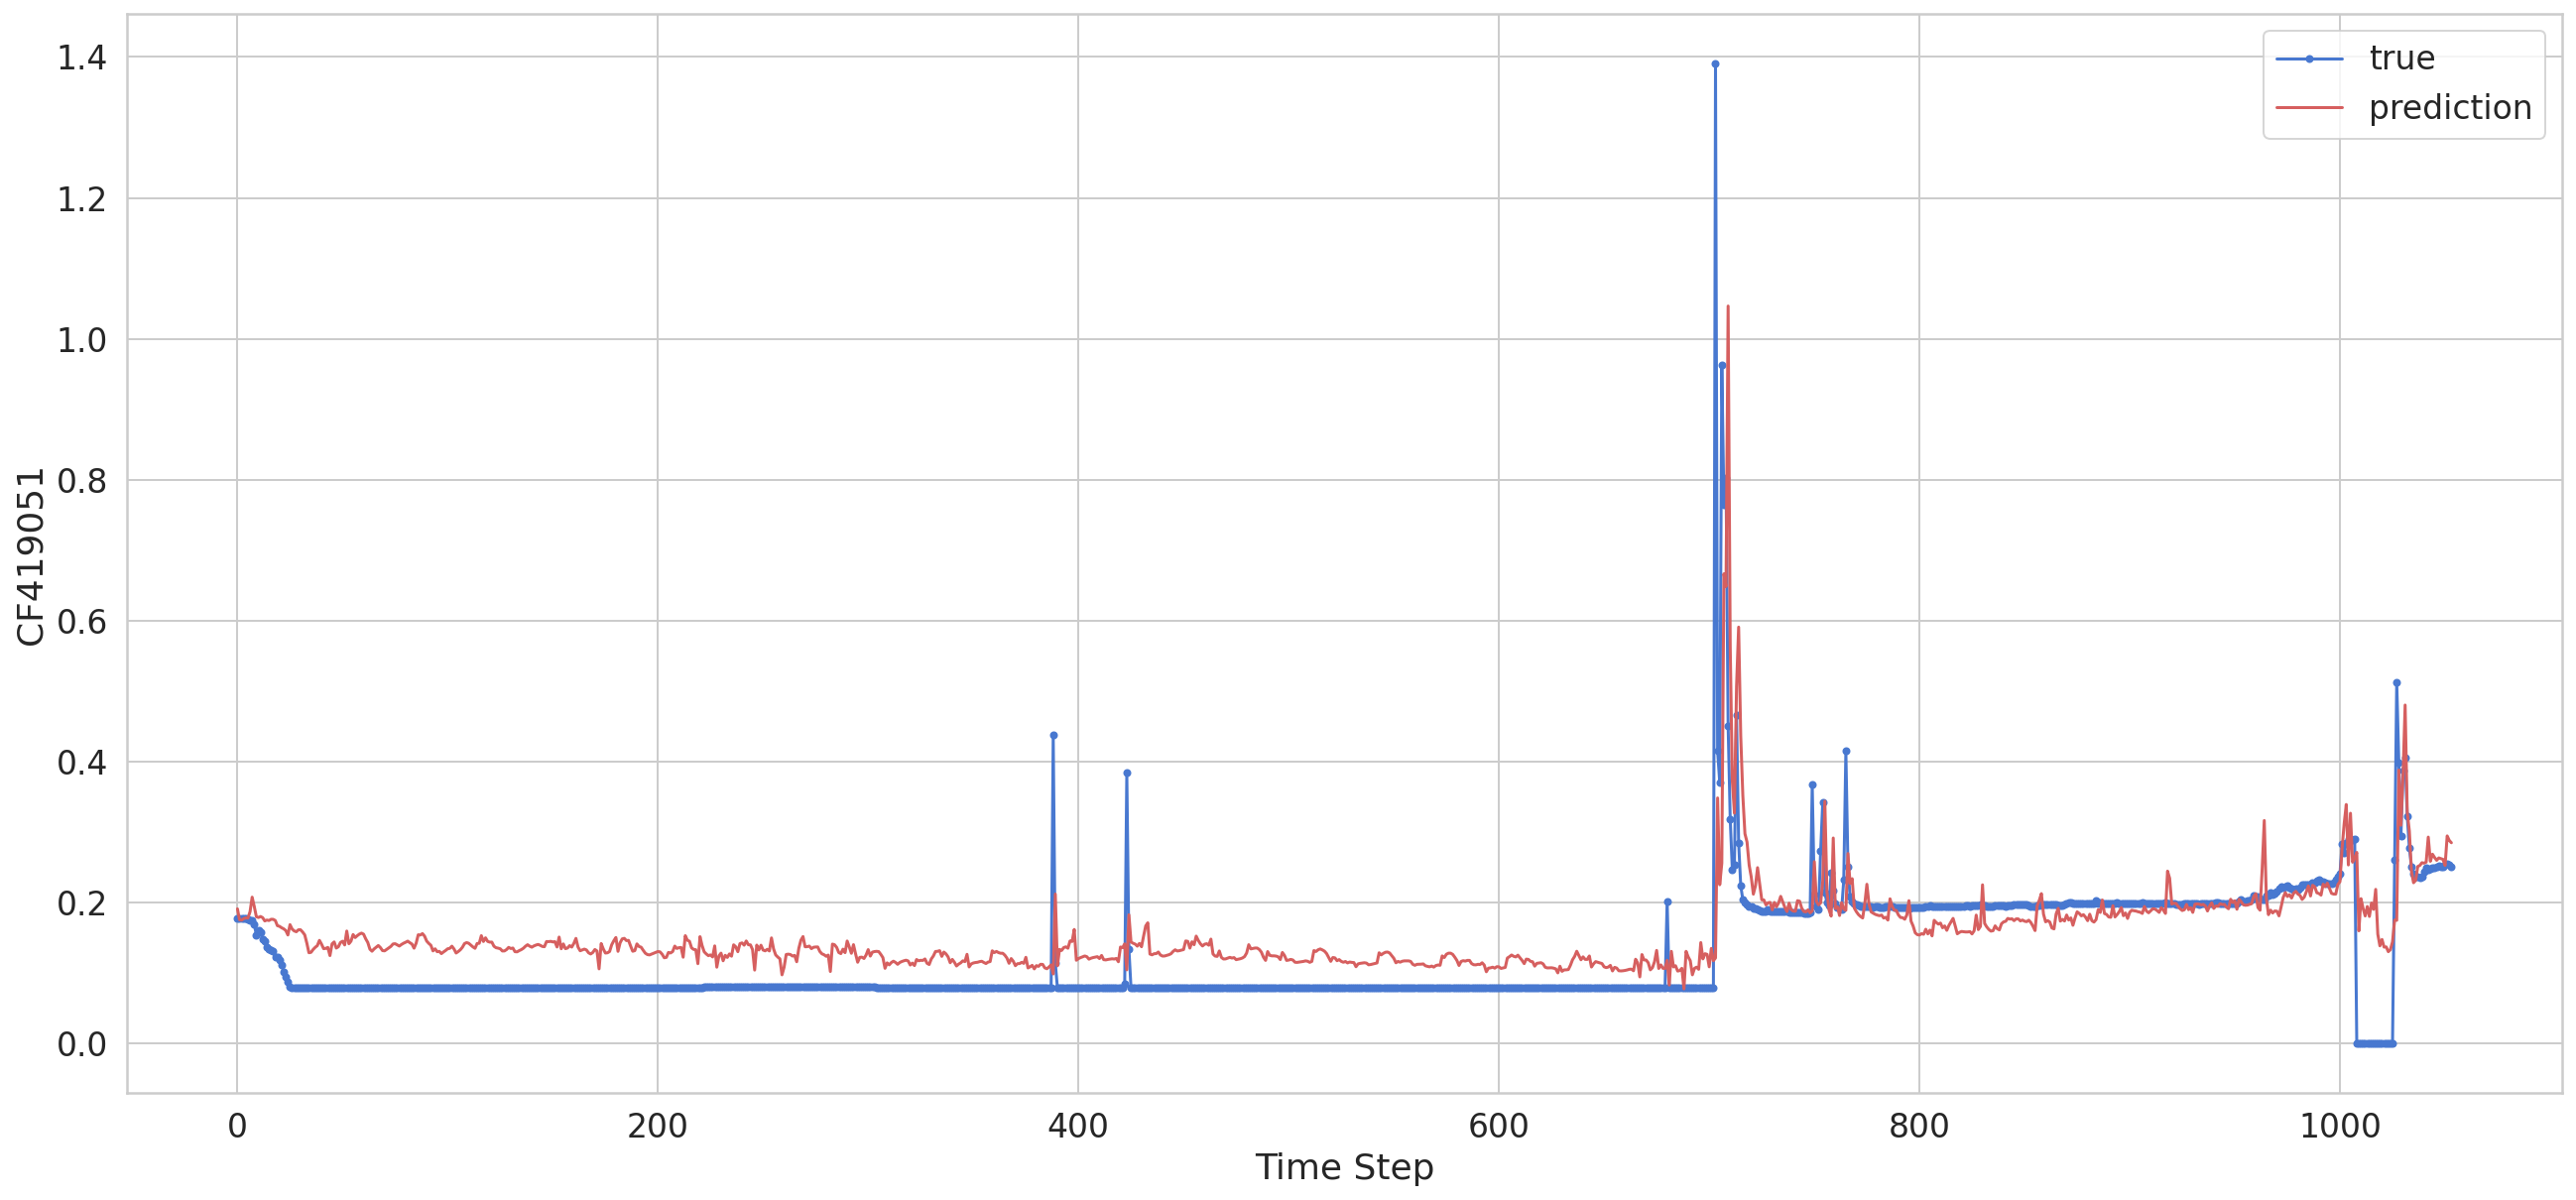

In [138]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('CF419051')
plt.xlabel('Time Step')
plt.legend()
plt.show();